In [2]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep

## loading and preparing data 

In [3]:
adata = sc.read("../data/haber_count.h5ad", backup_url="shorturl.at/imuEP")
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]
n_conditions = adata.obs["condition"].unique().shape[0]

In [4]:
adata_train = adata[~((adata.obs["cell_label"] == "TA")
                      & (adata.obs["condition"] == "Hpoly.Day10"))]

In [5]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)


         Falling back to preprocessing with `sc.pp.pca` and default params.


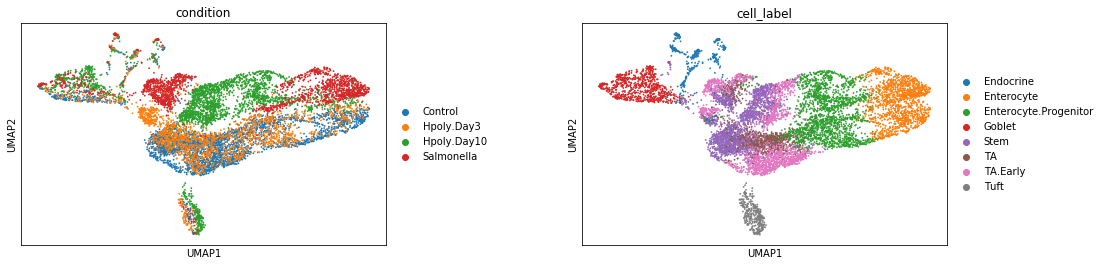

In [6]:
sc.pl.umap(adata_train, color=["condition", "cell_label"], wspace=.4)

## creating model object 

In [11]:
model = trvaep.CVAE(adata_train.n_vars, num_classes=n_conditions,
            encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
            use_mmd=True, beta=1)

### Make a trainer object 


In [12]:
trainer = trvaep.Trainer(model, adata_train)

In [13]:
trainer.train_trvae(100, 512)

Epoch 00/100 Batch 0000/15, Loss:  391.5903, rec_loss:  390.1749, KL_loss:    0.0002, MMD_loss:     1.4152
Epoch 00/100 Batch 0015/15, Loss:  225.1560, rec_loss:  223.9470, KL_loss:    0.0006, MMD_loss:     1.2084
Epoch 01/100 Batch 0000/15, Loss:  220.9290, rec_loss:  219.7899, KL_loss:    0.0006, MMD_loss:     1.1386
Epoch 01/100 Batch 0015/15, Loss:  164.6207, rec_loss:  163.4282, KL_loss:    0.0008, MMD_loss:     1.1917
Epoch 02/100 Batch 0000/15, Loss:  171.0268, rec_loss:  169.9448, KL_loss:    0.0008, MMD_loss:     1.0812
Epoch 02/100 Batch 0015/15, Loss:  145.3314, rec_loss:  144.0797, KL_loss:    0.0012, MMD_loss:     1.2505
Epoch 03/100 Batch 0000/15, Loss:  146.5441, rec_loss:  145.3983, KL_loss:    0.0012, MMD_loss:     1.1447
Epoch 03/100 Batch 0015/15, Loss:  132.3407, rec_loss:  131.3307, KL_loss:    0.0016, MMD_loss:     1.0084
Epoch 04/100 Batch 0000/15, Loss:  134.0371, rec_loss:  132.8787, KL_loss:    0.0016, MMD_loss:     1.1569
Epoch 04/100 Batch 0015/15, Loss:  12

Epoch 38/100 Batch 0000/15, Loss:   84.4616, rec_loss:   84.0048, KL_loss:    0.0083, MMD_loss:     0.4486
Epoch 38/100 Batch 0015/15, Loss:   88.4500, rec_loss:   87.9939, KL_loss:    0.0085, MMD_loss:     0.4476
Epoch 39/100 Batch 0000/15, Loss:   87.5281, rec_loss:   87.1610, KL_loss:    0.0086, MMD_loss:     0.3586
Epoch 39/100 Batch 0015/15, Loss:   87.8273, rec_loss:   87.4235, KL_loss:    0.0088, MMD_loss:     0.3949
Epoch 40/100 Batch 0000/15, Loss:   84.2801, rec_loss:   83.7600, KL_loss:    0.0085, MMD_loss:     0.5116
Epoch 40/100 Batch 0015/15, Loss:   88.4369, rec_loss:   88.0683, KL_loss:    0.0087, MMD_loss:     0.3599
Epoch 40, Loss_valid:  124.7903, rec_loss_valid:  117.6695, KL_loss_valid:    0.0127, MMD_loss:     4.1420 
Epoch 41/100 Batch 0000/15, Loss:   82.1886, rec_loss:   81.7440, KL_loss:    0.0088, MMD_loss:     0.4358
Epoch 41/100 Batch 0015/15, Loss:   84.6991, rec_loss:   84.2959, KL_loss:    0.0087, MMD_loss:     0.3945
Epoch 42/100 Batch 0000/15, Loss:   

Epoch 75/100 Batch 0015/15, Loss:   80.2341, rec_loss:   79.9478, KL_loss:    0.0123, MMD_loss:     0.2740
Epoch 76/100 Batch 0000/15, Loss:   81.9036, rec_loss:   81.5715, KL_loss:    0.0123, MMD_loss:     0.3198
Epoch 76/100 Batch 0015/15, Loss:   82.9629, rec_loss:   82.6197, KL_loss:    0.0128, MMD_loss:     0.3304
Epoch 77/100 Batch 0000/15, Loss:   84.7099, rec_loss:   84.4626, KL_loss:    0.0126, MMD_loss:     0.2347
Epoch 77/100 Batch 0015/15, Loss:   81.7901, rec_loss:   81.5354, KL_loss:    0.0125, MMD_loss:     0.2423
Epoch 78/100 Batch 0000/15, Loss:   81.2048, rec_loss:   80.9273, KL_loss:    0.0125, MMD_loss:     0.2651
Epoch 78/100 Batch 0015/15, Loss:   81.9645, rec_loss:   81.6926, KL_loss:    0.0129, MMD_loss:     0.2590
Epoch 79/100 Batch 0000/15, Loss:   79.4425, rec_loss:   79.1684, KL_loss:    0.0126, MMD_loss:     0.2615
Epoch 79/100 Batch 0015/15, Loss:   85.1088, rec_loss:   84.8309, KL_loss:    0.0124, MMD_loss:     0.2655
Epoch 80/100 Batch 0000/15, Loss:   8

## visualizing the MMD latent space

... storing 'cell_label' as categorical
... storing 'condition' as categorical


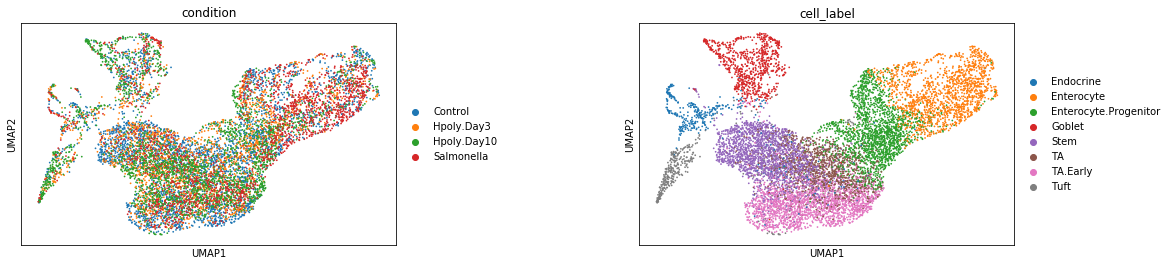

In [14]:
latent_y = model.get_y(
    adata.X, model.label_encoder.transform(adata.obs["condition"]))
adata_latent = sc.AnnData(latent_y)
adata_latent.obs["cell_label"] = adata.obs["cell_label"].tolist()
adata_latent.obs["condition"] = adata.obs["condition"].tolist()
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=["condition", "cell_label"], wspace=.5)

## Making prediction

... storing 'barcode' as categorical
... storing 'cell_label' as categorical
... storing 'condition' as categorical


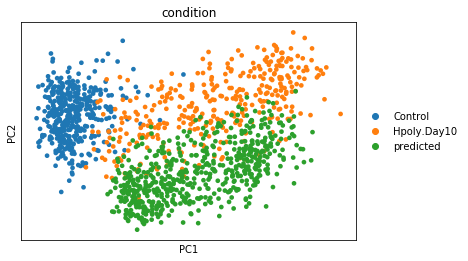

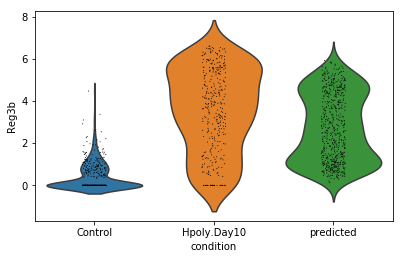

In [15]:
ground_truth = adata[((adata.obs["cell_label"] == "TA")
                      & (adata.obs["condition"].isin(["Hpoly.Day10", "Control"])))]
adata_source = adata[(adata.obs["cell_label"] == "Stem") &
                     (adata.obs["condition"] == "Hpoly.Day10")]
predicted_data = model.predict(x=adata_source.X, y=adata_source.obs["condition"].tolist(),
                               target="Hpoly.Day10")
adata_pred = sc.AnnData(predicted_data)
adata_pred.obs["condition"] = np.tile("predicted", len(adata_pred))
adata_pred.var_names = adata_source.var_names.tolist()
all_adata = ground_truth.concatenate(adata_pred)
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color=["condition"])
sc.pl.violin(all_adata, keys="Reg3b", groupby="condition")